# imports

In [1]:
from os import listdir,mkdir,makedirs
from os.path import isfile, join, isdir,exists
import pandas as pd
import numpy as np
from scipy import stats
import re
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from myplots import roundup, rounddown, find_decimal_fold, percentile_cut_off, rarefaction_calc, rarefaction_plot,draw_correlation_scatter
from matplotlib.ticker import FormatStrFormatter
import cPickle as pickle
from Bio.SeqUtils import GC
import seaborn as sns
import random
from scipy.stats import pearsonr,fisher_exact
from skbio.diversity.alpha import shannon, simpson, berger_parker_d

from pop_organize import get_sample_data, get_sample_with_dfs
from SufficientStatistics.SufficientStatistics import *
from MyFunctionsShani import *
import math
from myplots import roundup, rounddown, find_decimal_fold
from skbio.stats.distance import mantel
from scipy.spatial.distance import braycurtis, pdist
from GeneralFeaturePhenotypeInteractions.Feature_phenotype_functions import * 
from TCR_microbiome_interactions.TCR_microbiome_interactions_functions import *
from TCR_microbiome_interactions.TCR_microbiome_interactions_functions2 import *
from SampleLists.SampleFileFunctions import *

import os
from Utils import cacheOnDisk
from SegalQueue.qp import qp,fakeqp
from addloglevels import sethandlers

MyPath='/net/mraid08/export/genie/Lab/Personal/ShaniBAF'

done1
stop
stop
done1
stop
done
done
done
done


In [2]:
import time
cdate=str(time.strftime("%d%m%Y"))
cdate


'13022019'

# develop TCR/Mb generator

## define parameters

In [10]:

# parameters to change:
#general parameters:
DFtype='TCR'
genDF=True #False=generate new df
toBinary=True

#basic prameters for generating df:
mbLevel='g'
useShortName=True

datasetFolder='%s/TCR_real_data/PNP530Cardio126Combined/nonMatched/ss5000_rep3' %MyPath
datasetName='PNP530Cardio126_notMatched_ss5000rep2' 

#parameters for manipulations on df 
minVal=None    #minVal can be None,0, float, or 'dfMinVal' or dfMinVal2:
minSharedT=None #minimal number of samples shared by seq/species required to leave sample in the database (int or None)
percShared=10 #minimal number of samples shared by seq/species required to leave sample in the database (int [ percentage]
                #or None)
removeOutliers=True
normData=False
logTransform=False




#constant parameters:
extractUniqueAA=True # use True when this is the first time to analyze this dataset, otherwise, use False
minNshared=2
onlyProductive=True

mbDataFolder='AllSeqProjects'
with open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/Sample files/BD lists/PNP530','rb') as fp:
    PNP530=pickle.load(fp)
# with open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/Sample files/BD lists/Cardio126','rb') as fp:
#     Cardio126=pickle.load(fp)
# PNP530Cardio126list=PNP530+Cardio126
SampleList=None
SampleListName=None
libPrepMethod=None
filterGenotek=True
filterMinimalReads=9000000
filterlibPrepMethod=libPrepMethod
groupFunction='noOutlierMean'
nSTD=5
nMinSamples=3
ignoreNotSameYear=True
removeSamePerson=False




## load/generate df:

In [ ]:
# (1) load/ generate DF:

if DFtype=='Mb':
    if genDF:
        print 'generating MbDF...'
        df,filename=genFilterMergeMbData(mbLevel,mbDataFolder,SampleList,SampleListName,filterGenotek,filterMinimalReads,
                                filterlibPrepMethod, groupFunction,nSTD,nMinSamples,ignoreNotSameYear,useShortName)
    else:
        folderToSave = '%s/MicrobiomeDataTables/FilteredAndMergedOnBD' % MyPath
        try:
            filename = '%s/MPA_%s_standardParams' % (folderToSave, mbLevel)
            df=pd.read_pickle(filename)
            print 'loading existing MbDF: level=%s, standard params...' %mbLevel
        except:
            filename=  '%s/MPA_%s_%s_%s_fGenotek%s_fMinimalRead%s_libMeth%s_igAnotherYear%s_%snSTD%snMinSamples%s_fSamePerson%s' %(folderToSave,
                mbLevel,mbDataFolder,SampleListName,filterGenotek,filterMinimalReads,filterlibPrepMethod,ignoreNotSameYear,
                groupFunction,nSTD,nMinSamples,removeSamePerson)
            try:
                df=pd.read_pickle(filename)
                print 'loading existing MbDF: level=%s, long name...' %mbLevel
            except:
                print filename
                print 'file was not found...'
elif DFtype=='TCR':
    if genDF:
        minNsharedList=list(minNshared)
        print 'preparing sharing Matrix'
        TCRdf_RA,filename=gen_sharingMatrix_perDataset(datasetName,datasetFolder,minNsharedList,extractUniqueAA=False,
                                              getSharingStatistics=True)
    else:
        print 'loading existing TCR: datasetName=%s, minNshared=%s' %(datasetName,minNshared)
        try:
            filename='%s/sharingAnalysis/sharingMatrix_%s_minNshared%s_RA_onlyProductiveTrue' %(datasetFolder,datasetName,minNshared)
            print filename
            df=pd.read_pickle(filename)
            print 'load completed'
        except:
            print 'TCR file was not found'
    
    print 'checking if RA values are percentage values or real RA values:'
    currMinVal=df[df>0].min().min()
    print 'the minimal value of the DF is %s' %currMinVal
    
    if currMinVal>0.001:
        print 'the minimal value is %s, which is higher than 0.001. this means that RA values are percentage. dividing by 100\
to get real RA values...' %currMinVal
        df=df.div(100)
    else:
        print 'RA values are real RA values, no division is required'
    
else:
    print 'DFtype is not known'
    
print 'Number of analyzed units (seqs/species/genus) is %s' %len(df.columns)
print 'filename is %s' %filename


            
            
    


In [ ]:
print df.shape
print df.iloc[:5,:5]

In [ ]:
origDF=df.copy()

## cap value to minVal

### define minimal val:

In [ ]:
#minVal can be None,0, float, or 'dfMinVal' 
print 'setting minVal'
if minVal=='dfMinVal':
    minVal2=df[df>0].min().min()
    print 'minVal is set to the existing df minimal value: %s' %minVal2
elif minVal=='dfMinVal2':
    minVal2=(df[df>0].min().min())*2
    print 'minVal is set to the existing df minimal value: %s' %minVal2
else:
    minVal2=minVal
    print 'minVal remains %s as defined by user' %minVal2
    




### cap all values to minimal val:

In [ ]:
if minVal is not None:
    print 'capping to minVal=%s' %minVal2
    print 'df sum before capping is %s' %df.sum().sum()
    df=df.mask(df<minVal2)
    df=df.fillna(minVal2)
    df.head()
    print 'df sum after capping is %s' %df.sum().sum()
    name1='capped%s' %minVal
else:
    print 'no capping was applied'
    minVal2=0
    name1=''

## Leave only seq/species appear in specific number of samples  (use '2' to leave only shared seqs/species

In [ ]:
print minVal2

In [ ]:
#define minSharedT=minimal number of shared samples by each seq/species to leave in df, or-
# percShared = leave only seqs/species shared by specific percent of samples


if (minSharedT is not None) or (percShared is not None):
    print 'Number of analyzed units is %s' %len(df.columns)
    if minSharedT is not None:
        print 'leaving only units shared by %s samples or more' %minSharedT
        checkShared=df.apply(lambda x: True if len([i for i in x if i>minVal2])>=minSharedT else False)
        name2='minSharedT%s' %minSharedT
    elif percShared is not None:
        minSharedT=round(float(len(df))*percShared/100)
        print 'leaving only units shared by more than %s percent of the samples (%s samples)' %(percShared,minSharedT)
        checkShared=df.apply(lambda x: True if len([i for i in x if i>minVal2])>=minSharedT else False)
        name2='percShared%s' %percShared
    shared=checkShared[checkShared]
    df=df[shared.index]
    print 'number of analyzed units is now %s' %len(df.columns)
else:
    print 'no units were removed due to low sharing level, number of units remains %s'  %len(df.columns)
    name2=''


## Check outliers and trim to the maximal allowed value (not for binary!)

## trim outliers

In [ ]:
if removeOutliers:
    print 'removing outliers, outlierSTD=5, trim=True...'
    df2=df.copy()
    df=filter_outliers(df,outlierSTD=5,columnList=None,trim=True)
    name3='OLtrimmed'
else:
    name3=''
    

### plot max and min values distribution to follow correct removal

In [ ]:

print 'plotting values distribution before and after trimming...'
fig,axes=plt.subplots(nrows=1,ncols=2, figsize=(8,2))
ax1=axes[0]
x1=df2.min().tolist()
y1=df.min().tolist()
ax1.hist([x1,y1],color=['blue','red'],bins=20,label=['before trimming','after trimming'],alpha=0.5)
print 'now the second'
ax1.set_yscale('log')
ax1.legend()
ax1.set_title('max RA value distribution before\nand after trimming')
ax1.set_xlabel('RA values')
ax1.set_ylabel('freq')
ax1.xaxis.set_major_locator(plt.MaxNLocator(4))

ax2=axes[1]
x2=df2.max().tolist()
y2=df.max().tolist()
ax2.hist([x2,y2],color=['blue','red'],bins=20,label=['before trimming','after trimming'],alpha=0.5)
print 'now the second'
ax2.set_yscale('log')
ax2.legend()
ax2.set_title('min RA value distribution before\nand after trimming')
ax2.set_xlabel('RA values')
ax2.set_ylabel('freq')
ax2.xaxis.set_major_locator(plt.MaxNLocator(4))
plt.show()

## Binarize data (only if not normed, use minimal value as zero) t

In [ ]:
print df.iloc[:4,:4]
if toBinary:
    print 'binarizing df...'
    dfBinary=df.mask(df<=minVal2)
    dfBinary=dfBinary.fillna(0)
    dfBinary=dfBinary.mask(dfBinary!=0)
    dfBinary=dfBinary.fillna(1)
    print 'existing values in df are now:'
    print pd.unique(dfBinary.values.ravel('K'))
    print df.iloc[:4,:4]
    print dfBinary.iloc[:4,:4]
    


## Norm data (not for binary!)

In [ ]:
if normData:
    normeddf=df.div(df.sum(axis=1),axis=0)
    print df.sum(axis=1).head()
    print normeddf.sum(axis=1).head()
    

##  log transformation (not for binary!)

In [ ]:
if logTransform:
    logdf=df.apply(lambda x: np.log10(x))
    logdf.describe()


## generate some summarizing parameters on the df and save

### generate final filename

In [ ]:
finalFileName='%s_%s_%s_%s' %(filename, name1,name2,name3)
finalFileName=finalFileName.replace('.','_')
print finalFileName

In [ ]:
name=finalFileName.split('/')[-1]
print name

### plot mean sample value distribution for each df:

In [ ]:
dfList=[origDF,df]
dfListNames=['origDF',name]
try:
    dfList.append(dfBinary)
    dfListNames.append('dfBinary')
except:
    dfList.append(None)
    dfListNames.append(None)

try:
    dfList.append(normeddf)
    dfListNames.append('normeddf')
except:
    dfList.append(None)
    dfListNames.append(None)

try:
    dfList.append(logdf)
    dfListNames.append('logdf')
except:
    dfList.append(None)
    dfListNames.append(None)
    
print len(dfList)

In [ ]:
for n,dfx in enumerate(dfList):
    if dfx is not None:
        print n
        print dfListNames[n]
        print dfx.iloc[:3,:3]

In [ ]:
print 'plotting mean sample distributions for all generated dfs...'
dfListNew=[x for x in dfList if x is not None]
dfListNamesNew=[x for x in dfListNames if x is not None]

llen=len(dfListNew)
fig,axes=plt.subplots(nrows=1, ncols=llen,figsize=(4*llen,2))
fig.suptitle ('RA value distributions',fontweight='bold')
for n,dfx in enumerate(dfListNew):
    print n
    print dfListNamesNew[n]
    print dfx.iloc[:3,:3]
    ax=axes[n]
    x=dfx.mean(axis=1).tolist()
    ax.hist(x)
    ax.set_yscale('log')
    ax.set_title(dfListNamesNew[n])
#     ax.set_xlabel('RA values')
    if n==0:
        ax.set_ylabel('freq')
    if n==1:
        title=dfListNamesNew[n]
        firstpart, secondpart =title[:len(title)/2], title[len(title)/2:]
        ax.set_title('%s\n%s' %(firstpart, secondpart))
    ax.xaxis.set_major_locator(plt.MaxNLocator(3))
    
fig.subplots_adjust(top=0.7,wspace=0.4)
    
plt.show()

    
    

In [ ]:
print 'plotting RA value distributions for all generated dfs IN A RANDOM SAMPLE'
import random
dfListNew=[x for x in dfList if x is not None]
dfListNamesNew=[x for x in dfListNames if x is not None]

llen=len(dfListNew)
fig,axes=plt.subplots(nrows=1, ncols=llen,figsize=(4*llen,2))

sample=random.sample(df.index, 1)

fig.suptitle ('RA value distributions in sample %s' %sample[0],fontweight='bold')
for n,dfx in enumerate(dfListNew):
    print n
    print dfListNamesNew[n]
    print dfx.iloc[:3,:3]
    ax=axes[n]
    x=dfx.loc[sample,:].values.flatten().tolist()
    ax.hist(x,bins=20)
    ax.set_yscale('log')
    ax.set_title(dfListNamesNew[n])
#     ax.set_xlabel('RA values')
    if n==0:
        ax.set_ylabel('freq')
    if n==1:
        title=dfListNamesNew[n]
        firstpart, secondpart =title[:len(title)/2], title[len(title)/2:]
        ax.set_title('%s\n%s' %(firstpart, secondpart))
    ax.xaxis.set_major_locator(plt.MaxNLocator(3))
fig.subplots_adjust(top=0.62,wspace=0.4)
    
plt.show()

## save files:

In [ ]:
print 'saving df to file...'
df.to_pickle(finalFileName)

try:
    dfBinary.to_pickle('%s_binary' %finalFileName)
    print 'saving binary df to file'
except:
    pass

try:
    normeddf.to_pickle('%s_normed' %finalFileName)
    print 'saving normed df to file'
except:
    pass

try:
    logdf.to_pickle('%s_log' %finalFileName)
    print 'saving log df to file'
except:
    pass


print 'ALL is done!!!'


In [ ]:
print origDF.iloc[:3,:3]
print df.iloc[:3,:3]
print dfBinary.iloc[:3,:3]
print normeddf.iloc[:3,:3]
print logdf.iloc[:3,:3]



# define function:


the function genTCRorMBdfWithManipulations was copied to TCR_microbiome_interactions_functions2

the function is based on the development seen above

# run function:

In [ ]:
df=genTCRorMBdfWithManipulations(DFtype,genDF,toBinary,removeOutliers,normData,logTransform,
                                 minVal,minSharedT,percShared,
                                 mbLevel,useShortName,datasetFolder,datasetName,extractUniqueAA,
                                minNshared=2,onlyProductive=True,mbDataFolder='AllSeqProjects',SampleList=PNP530,
                                  SampleListName='PNP530',filterlibPrepMethod=None,filterGenotek=True, 
                                  groupFunction='noOutlierMean', nSTD=5, nMinSamples=3, ignoreNotSameYear=True, removeSamePerson=False)


## run for PNP530_ss9000

In [ ]:
DFtype='TCR'
genDF=True #False=generate new df
toBinary=True

datasetFolder='%s/TCR_real_data/PNP530_SubSampled9000data_rep1' %MyPath
datasetName='PNP530_ss9000_rep1'

#parameters for manipulations on df 
minVal=None    #minVal can be None,0, float, or 'dfMinVal' or dfMinVal2:
minSharedT=None #minimal number of samples shared by seq/species required to leave sample in the database (int or None)
percShared=10 #minimal number of samples shared by seq/species required to leave sample in the database (int [ percentage]
                #or None)
removeOutliers=True
normData=True
logTransform=True

minNshared=50

In [ ]:
df=genTCRorMBdfWithManipulations(DFtype,genDF,toBinary,removeOutliers,normData,logTransform,
                                 minVal,minSharedT,percShared,
                                 mbLevel,useShortName,datasetFolder,datasetName,extractUniqueAA,
                                minNshared=2,onlyProductive=True,mbDataFolder='AllSeqProjects',SampleList=PNP530,
                                  SampleListName='PNP530',filterlibPrepMethod=None,filterGenotek=True, 
                                  groupFunction='noOutlierMean', nSTD=5, nMinSamples=3, ignoreNotSameYear=True, removeSamePerson=False)


## run for cardio126_ss9000

In [ ]:
DFtype='TCR'
genDF=True #False=generate new df
toBinary=True

datasetFolder='%s/TCR_real_data/CardioSamples/Cardio126_SubSampled9000data_rep1' %MyPath
datasetName='Cardio126_ss9000_rep1'

#parameters for manipulations on df 
minVal=None    #minVal can be None,0, float, or 'dfMinVal' or dfMinVal2:
minSharedT=None #minimal number of samples shared by seq/species required to leave sample in the database (int or None)
percShared=10 #minimal number of samples shared by seq/species required to leave sample in the database (int [ percentage]
                #or None)
removeOutliers=True
normData=False
logTransform=False

minNshared=2

df=genTCRorMBdfWithManipulations(DFtype,genDF,toBinary,removeOutliers,normData,logTransform,
                                 minVal,minSharedT,percShared,
                                 mbLevel,useShortName,datasetFolder,datasetName,extractUniqueAA,
                                minNshared=2,onlyProductive=True,mbDataFolder='AllSeqProjects',SampleList=PNP530,
                                  SampleListName='PNP530',filterlibPrepMethod=None,filterGenotek=True, 
                                  groupFunction='noOutlierMean', nSTD=5, nMinSamples=3, ignoreNotSameYear=True, removeSamePerson=False)


In [ ]:
minSharedT=2 #minimal number of samples shared by seq/species required to leave sample in the database (int or None)
percShared=None #minimal number of samples shared by seq/species required to leave sample in the database (int [ percentage]
                #or None)

df=genTCRorMBdfWithManipulations(DFtype,genDF,toBinary,removeOutliers,normData,logTransform,
                                 minVal,minSharedT,percShared,
                                 mbLevel,useShortName,datasetFolder,datasetName,extractUniqueAA,
                                minNshared=2,onlyProductive=True,mbDataFolder='AllSeqProjects',SampleList=PNP530,
                                  SampleListName='PNP530',filterlibPrepMethod=None,filterGenotek=True, 
                                  groupFunction='noOutlierMean', nSTD=5, nMinSamples=3, ignoreNotSameYear=True, removeSamePerson=False)


## run for PNP530Cardio126

In [ ]:
df=genTCRorMBdfWithManipulations(DFtype,genDF,toBinary,removeOutliers,normData,logTransform,
                                 minVal,minSharedT,percShared,
                                 mbLevel,useShortName,datasetFolder,datasetName,extractUniqueAA,
                                minNshared,onlyProductive,mbDataFolder,SampleList,
                                  SampleListName,filterlibPrepMethod,filterGenotek, 
                                  groupFunction, nSTD, nMinSamples, ignoreNotSameYear, removeSamePerson)

## run for PNP530_ss5000

In [ ]:
DFtype='TCR'
genDF=True #False=generate new df
toBinary=True

datasetFolder='%s/TCR_real_data/PNP530_SubSampled5000data_rep1' %MyPath
datasetName='PNP530_ss5000_rep1'

#parameters for manipulations on df 
minVal=None    #minVal can be None,0, float, or 'dfMinVal' or dfMinVal2:
minSharedT=2 #minimal number of samples shared by seq/species required to leave sample in the database (int or None)
percShared=None #minimal number of samples shared by seq/species required to leave sample in the database (int [ percentage]
                #or None)
removeOutliers=True
normData=True
logTransform=True

minNshared=2

df=genTCRorMBdfWithManipulations(DFtype,genDF,toBinary,removeOutliers,normData,logTransform,
                                 minVal,minSharedT,percShared,
                                 mbLevel,useShortName,datasetFolder,datasetName,extractUniqueAA,
                                minNshared,onlyProductive,mbDataFolder,SampleList,
                                  SampleListName,filterlibPrepMethod,filterGenotek, 
                                  groupFunction, nSTD, nMinSamples, ignoreNotSameYear, removeSamePerson)


In [ ]:
DFtype='TCR'
genDF=False #False=generate new df
toBinary=True

datasetFolder='%s/TCR_real_data/PNP530_SubSampled5000data_rep1' %MyPath
datasetName='PNP530_ss5000_rep1'

#parameters for manipulations on df 
minVal=None    #minVal can be None,0, float, or 'dfMinVal' or dfMinVal2:
minSharedT=None #minimal number of samples shared by seq/species required to leave sample in the database (int or None)
percShared=10 #minimal number of samples shared by seq/species required to leave sample in the database (int [ percentage]
                #or None)
removeOutliers=True
normData=True
logTransform=True
extractUniqueAA=False
minNshared=2

df=genTCRorMBdfWithManipulations(DFtype,genDF,toBinary,removeOutliers,normData,logTransform,
                                 minVal,minSharedT,percShared,
                                 mbLevel,useShortName,datasetFolder,datasetName,extractUniqueAA,
                                minNshared,onlyProductive,mbDataFolder,SampleList,
                                  SampleListName,filterlibPrepMethod,filterGenotek, 
                                  groupFunction, nSTD, nMinSamples, ignoreNotSameYear, removeSamePerson)


## run for Cardio126_ss5000

In [ ]:
# minNshared=2


# parameters to change:
#general parameters:
DFtype='TCR'
genDF=True #False=generate new df
toBinary=True

#basic prameters for generating df:
mbLevel='g'
useShortName=True

datasetFolder='%s/TCR_real_data/CardioSamples/Cardio126_SubSampled5000data_rep1' %MyPath
datasetName='Cardio126_ss5000_rep1' 

#parameters for manipulations on df 
minVal=None    #minVal can be None,0, float, or 'dfMinVal' or dfMinVal2:
minSharedT=2 #minimal number of samples shared by seq/species required to leave sample in the database (int or None)
percShared=None #minimal number of samples shared by seq/species required to leave sample in the database (int [ percentage]
                #or None)
removeOutliers=True
normData=True
logTransform=True




#constant parameters:
extractUniqueAA=True # use True when this is the first time to analyze this dataset, otherwise, use False
minNshared=2
onlyProductive=True

mbDataFolder='AllSeqProjects'
with open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/Sample files/BD lists/PNP530','rb') as fp:
    PNP530=pickle.load(fp)
with open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/Sample files/BD lists/Cardio126','rb') as fp:
    Cardio126=pickle.load(fp)
PNP530Cardio126list=PNP530+Cardio126
SampleList=PNP530
SampleListName='Cardio126'
libPrepMethod=None
filterGenotek=True
filterMinimalReads=9000000
filterlibPrepMethod=libPrepMethod
groupFunction='noOutlierMean'
nSTD=5
nMinSamples=3
ignoreNotSameYear=True
removeSamePerson=False




df=genTCRorMBdfWithManipulations(DFtype,genDF,toBinary,removeOutliers,normData,logTransform,
                                 minVal,minSharedT,percShared,
                                 mbLevel,useShortName,datasetFolder,datasetName,extractUniqueAA,
                                minNshared,onlyProductive,mbDataFolder,SampleList,
                                  SampleListName,filterlibPrepMethod,filterGenotek, 
                                  groupFunction, nSTD, nMinSamples, ignoreNotSameYear, removeSamePerson)


In [ ]:
# min perc shared =10

DFtype='TCR'
genDF=False #False=generate new df
toBinary=True


#parameters for manipulations on df 
minVal=None    #minVal can be None,0, float, or 'dfMinVal' or dfMinVal2:
minSharedT=None #minimal number of samples shared by seq/species required to leave sample in the database (int or None)
percShared=10 #minimal number of samples shared by seq/species required to leave sample in the database (int [ percentage]
                #or None)
removeOutliers=True
normData=True
logTransform=True
extractUniqueAA=False
minNshared=2

df=genTCRorMBdfWithManipulations(DFtype,genDF,toBinary,removeOutliers,normData,logTransform,
                                 minVal,minSharedT,percShared,
                                 mbLevel,useShortName,datasetFolder,datasetName,extractUniqueAA,
                                minNshared,onlyProductive,mbDataFolder,SampleList,
                                  SampleListName,filterlibPrepMethod,filterGenotek, 
                                  groupFunction, nSTD, nMinSamples, ignoreNotSameYear, removeSamePerson)


# run for PNP530 (21102018)

In [ ]:
#TO GENERATE TCRDF WITH *ALL* shared sequences!! (nMinSahred=2)
df=genTCRorMBdfWithManipulations(DFtype,genDF,toBinary,removeOutliers,normData,logTransform,
                                 minVal,minSharedT,percShared,
                                 mbLevel,useShortName,datasetFolder,datasetName,extractUniqueAA,
                                minNshared,onlyProductive,mbDataFolder,SampleList,
                                  SampleListName,filterlibPrepMethod,filterGenotek, 
                                  groupFunction, nSTD, nMinSamples, ignoreNotSameYear, removeSamePerson)


In [ ]:
### save df in an efficient manner

In [ ]:
from pandas import HDFStore,DataFrame# create (or open) an hdf5 file and opens in append mode
hdf =HDFStore('storage.h5')

In [ ]:
f1='%s/sharingMatrix_PNP530_minNshared2_RA_onlyProductiveTrue.h5' %MyPath
hdf =HDFStore(f1)

In [ ]:
df.head()

In [ ]:
df.info()

In [ ]:
hdf.put('d1', df, format='table', data_columns=True)

## run for Cardio126 (15082018)

In [ ]:
df=genTCRorMBdfWithManipulations(DFtype,genDF,toBinary,removeOutliers,normData,logTransform,
                                 minVal,minSharedT,percShared,
                                 mbLevel,useShortName,datasetFolder,datasetName,extractUniqueAA,
                                minNshared,onlyProductive,mbDataFolder,SampleList,
                                  SampleListName,filterlibPrepMethod,filterGenotek, 
                                  groupFunction, nSTD, nMinSamples, ignoreNotSameYear, removeSamePerson)


## run for PNP530Cardio126 (11102018)

preparing sharing Matrix
extracting unique aa sequenecs from all samples...(n=646)
0 BD1016_5000.tsv
1 BD184_2_5000.tsv
2 BD881_5000.tsv
3 BD437_5000.tsv
4 BD1019_5000.tsv
5 BD161_322939_2_5000.tsv
6 BD438_5000.tsv
7 BD504_5000.tsv
8 BD233_5000.tsv
9 BD867_5000.tsv
10 BD579_1_5000.tsv
11 BD868_5000.tsv
12 BD553_5000.tsv
13 BD764_1_5000.tsv
14 BD830_5000.tsv
15 BD717_1_5000.tsv
16 BD903_5000.tsv
17 BD460_5000.tsv
18 BD357_5000.tsv
19 BD701_1_5000.tsv
20 BD694_1_5000.tsv
21 BD428_5000.tsv
22 BD1009_5000.tsv
23 BD664_1_5000.tsv
24 BD891_5000.tsv
25 BD427_5000.tsv
26 BD1006_5000.tsv
27 BD944_5000.tsv
28 BD878_5000.tsv
29 BD682_1_5000.tsv
30 BD877_5000.tsv
31 BD499_5000.tsv
32 BD794_5000.tsv
33 BD496_5000.tsv
34 BD543_5000.tsv
35 BD19_5000.tsv
36 BD449_2_5000.tsv
37 BD16_5000.tsv
38 BD140_322939_2_5000.tsv
39 BD292_5000.tsv
40 BD913_5000.tsv
41 BD1051_5000.tsv
42 BD848_5000.tsv
43 BD992_5000.tsv
44 BD524_5000.tsv
45 BD847_5000.tsv
46 BD974_5000.tsv
47 BD1036_5000.tsv
48 BD417_5000.tsv
49 BD

412 BD690_1_5000.tsv
413 BD971_5000.tsv
414 BD1033_5000.tsv
415 BD149_322939_2_5000.tsv
416 BD998_5000.tsv
417 BD842_5000.tsv
418 BD605_1_5000.tsv
419 BD997_5000.tsv
420 BD521_5000.tsv
421 BD760_5000.tsv
422 BD182_5000.tsv
423 BD355_5000.tsv
424 BD901_5000.tsv
425 BD22_322939_2_5000.tsv
426 BD832_5000.tsv
427 BD484_5000.tsv
428 BD551_5000.tsv
429 BD865_5000.tsv
430 BD231_5000.tsv
431 BD506_5000.tsv
432 BD959_5000.tsv
433 BD435_5000.tsv
434 BD883_5000.tsv
435 BD956_5000.tsv
436 BD1053_5000.tsv
437 BD911_5000.tsv
438 BD14_5000.tsv
439 BD144_322939_2_5000.tsv
440 BD541_5000.tsv
441 BD276_5000.tsv
442 BD151_322939_2_5000.tsv
443 BD799_5000.tsv
444 BD494_5000.tsv
445 BD796_5000.tsv
446 BD221_5000.tsv
447 BD516_5000.tsv
448 BD875_5000.tsv
449 BD946_5000.tsv
450 BD614_1_5000.tsv
451 BD1004_5000.tsv
452 BD697_1_5000.tsv
453 BD425_5000.tsv
454 BD893_5000.tsv
455 BD949_5000.tsv
456 BD667_1_5000.tsv
457 BD727_5000.tsv
458 BD393_5000.tsv
459 BD7_5000.tsv
460 BD8_5000.tsv
461 BD442_5000.tsv
462 BD2

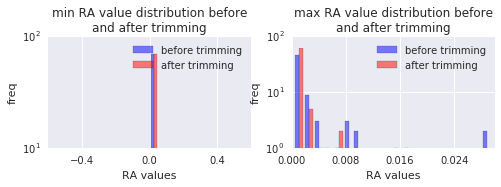

binarizing df...
existing values in df are now:
[0. 1.]
final file name is:
/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_real_data/PNP530Cardio126Combined/nonMatched/ss5000_rep3/sharingAnalysis/sharingMatrix_PNP530Cardio126_notMatched_ss5000rep2_minNshared2_RA_onlyProductiveTrue__percShared10_OLtrimmed
plotting mean sample distributions for all generated dfs...
0 (646, 150045)
origDF is too big, plot was not generated
1 (646, 69)
2 (646, 69)


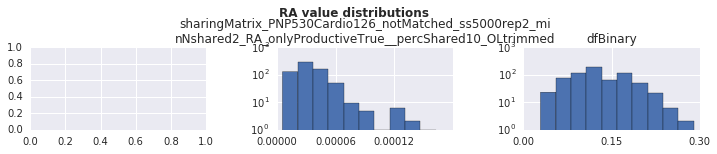

plotting RA value distributions for all generated dfs IN A RANDOM SAMPLE


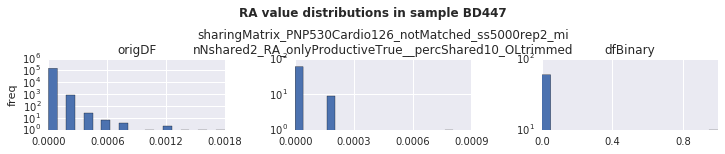

saving df to file...
saving binary df to file
ALL is done!!!


In [11]:
df=genTCRorMBdfWithManipulations(DFtype,genDF,toBinary,removeOutliers,normData,logTransform,
                                 minVal,minSharedT,percShared,
                                 mbLevel,useShortName,datasetFolder,datasetName,extractUniqueAA,
                                minNshared,onlyProductive,mbDataFolder,SampleList,
                                  SampleListName,filterlibPrepMethod,filterGenotek, 
                                  groupFunction, nSTD, nMinSamples, ignoreNotSameYear, removeSamePerson)


# improve function to enable filtering by sample List:

In [ ]:
def gen_sharingMatrix_perDataset(datasetName,dataset_folder,minNsharedList,sampleList=None,sampleListName=None,extractUniqueAA=True,getSharingStatistics=True,onlyProductive=True):
    
    #(1) define files and folders:
    try:
        sample_folder='%s/SamplesForAnalysis_corrected' %dataset_folder
    except:
        sample_folder='%s/SamplesForAnalysis' %dataset_folder
    if sampleList is None:
        sharingDFfolder='%s/sharingDFs' %dataset_folder
        sharingAnalysisFolder='%s/sharingAnalysis' %dataset_folder
    else:
        print 'only samples included in %s sample list are included in the analysis' %sampleListName
        sharingDFfolder='%s/%s_sharingDFs' %(dataset_folder,sampleListName)
        sharingAnalysisFolder='%s/%s_sharingAnalysis' %(dataset_folder,sampleListName)
     
    if not isdir(sharingDFfolder):
        makedirs(sharingDFfolder)
    if not isdir(sharingAnalysisFolder):
        makedirs(sharingAnalysisFolder)
    
    #(2) #get sample files:
    sharingFiles=[f for f in listdir(sharingDFfolder) if isfile(join(sharingDFfolder, f))]
    samples = [f for f in listdir(sample_folder) if isfile(join(sample_folder, f))]
    
    if sampleList is not None:
        print 'getting all samples from the sampleList...'
        #get 'clean name' samples to enable comparison
        cleanSamples=editSampleNamesList(samples)
        cleanSampleList=editSampleNamesList(sampleList)

        filteredSamples=[]
        for n,sample in enumerate(samples):
            cleanSample=cleanSamples[n]
            if cleanSample in cleanSampleList:
                filteredSamples.append(sample)
        samples=filteredSamples

    
    # (3)extract unique aa sequences from all samples:
    if extractUniqueAA:
        print 'extracting unique aa sequenecs from all samples...(n=%s)' %len(samples)
        for n,sample in enumerate(samples):
        #     if n<5:
                print n,sample
                uniqueAAfile='%s/%s' %(sharingDFfolder,sample)
#                 if sampleList is not None:
#                     uniqueAAfile='%s/%s_FsampleList%s' %(sharingDFfolder,sample,sampleListName)
                if uniqueAAfile not in sharingFiles:
#                     data_folder='TCR_real_data'
                    sample_df=pd.read_table('%s/%s' %(sample_folder,sample))
                    sample_df=sample_df.rename(columns={'count (templates/reads)':'count (templates)','count (reads)':'count (templates)'})
                    sample_df['prod_stat']=np.where(sample_df['sequenceStatus'] == 'In',1,0)
                    f={'frequencyCount (%)':'sum','prod_stat':'mean'}
                    uniqAA=sample_df.groupby('aminoAcid').agg(f)
        #             uniqAA=uniqAA.drop(('frequencyCount (%)','count'),axis=1)
                    uniqAA['Sample']=sample.split('_')[0]
                    uniqAA.to_pickle(uniqueAAfile)
        #             print uniqAA.head()
                else:
                    print('found uniqueAAdf for this sample...')
    else:
        print 'skipping unique aa sequences extraction...'
                
    # (4) generate df with all sequences and nShared counts:
    print 'generating a df with all sequences and number of samples shared...'
    #concatenate all uniqueAA lists from all samples:
    AllUnique=concat_summarizing_dfs(sharingDFfolder)
    print AllUnique.head()
#     if sampleList is not None:
#         print 'but only samples in the sample list are used for sharing analysis:'
# #         print 'samples:'
# #         print samples
# #         print 'AllUnique.sample values:'
# #         print AllUnique['Sample'].unique()
#         AllUnique=AllUnique[AllUnique['Sample'].isin(cleanSamples)]
#         print AllUnique.head()
        
    #count number of repeats:
    nSharedCount=AllUnique.index.value_counts()
    #merge with former df:
    AllUniqueWithCounts=pd.merge(AllUnique,pd.DataFrame(nSharedCount),how='left',left_index=True,right_index=True)
    #edit df:
    AllUniqueWithCounts=AllUniqueWithCounts.rename(columns={'aminoAcid':'nShared'})
    AllUniqueWithCounts['isPublic']=np.where(AllUniqueWithCounts['nShared']>1,1,0)
    #save AllUniqueWithCounts
    file1='%s/AllUniqueWithCounts' %sharingAnalysisFolder
#     if sampleList is not None:
#         file1='%s/AllUniqueWithCounts_FsampleList%s' %(sharingAnalysisFolder,sampleListName)
    AllUniqueWithCounts.to_pickle(file1)
    
    if onlyProductive:
        print 'USING ONLY PRODUCTIVE SEQUENCES TO GENERATE SHARING MATRIX!!!'
        AllUniqueWithCounts=AllUniqueWithCounts[AllUniqueWithCounts['prod_stat']==1]
        print 'filtering out strange sequences:...'
        AllUniqueWithCounts['seqLen']=AllUniqueWithCounts.index.str.len()
        AllUniqueWithCounts[~((AllUniqueWithCounts['seqLen']<3)&(AllUniqueWithCounts['nShared']<3))]
    
    
    #(5) get some sharing sequence statistics:
    if getSharingStatistics:
        print 'maximal number of shared samples per sequence for dataset %s (filtered by sample List %s) is %s' %(datasetName,sampleListName,AllUniqueWithCounts['nShared'].max())
        noDups=AllUniqueWithCounts.reset_index().drop_duplicates(subset='index')
        print 'percPublic=%s' %(noDups['isPublic'].mean()*100)
        print 'mean number of shared samples per sequence is %s'%noDups['nShared'].mean()
        print 'mean percPublic per sample=%s' %AllUniqueWithCounts.groupby('Sample')['isPublic'].apply(lambda x: np.mean(x)*100).mean()
        print 'mean nShared per sample=%s' %AllUniqueWithCounts.groupby('Sample')['nShared'].apply(lambda x: np.mean(x)).mean()
    
    #get only sequences shared by more than minNshared:
    print 'total number of unique aa seqeunces in the dataset is %s' %AllUniqueWithCounts.index.nunique()
    for minNshared in minNsharedList:
        print 'generating sharing matrix for minNshared=%s...' %minNshared
        sharedSeqs=AllUniqueWithCounts[AllUniqueWithCounts['nShared']>=minNshared]
        print 'number of unique sequences shared by %s samples or more is %s' %(minNshared,sharedSeqs.index.nunique())
        sharedSeqsClean=sharedSeqs.reset_index().rename(columns={'index':'Sequence'})
        
        #generate pivot tables:
        sharingMatrix_RA=sharedSeqsClean.pivot(index='Sample',columns='Sequence',values='frequencyCount (%)')
        sharingMatrix_RA=sharingMatrix_RA.fillna(0)
        sharingMatrix_RA=sharingMatrix_RA=editSampleNames(sharingMatrix_RA)
        print 'isPublic status is %s and should be 1' %sharedSeqsClean['isPublic'].mean()
        print 'sharingMatrix_RA shape is %s_%s' %(sharingMatrix_RA.shape[0],sharingMatrix_RA.shape[1])
        
        #divide all values by 100 in order to get real RA values and not percents
        sharingMatrix_RA=sharingMatrix_RA.div(100)
        
        RA_file='%s/sharingMatrix_%s_minNshared%s_RA_onlyProductive%s' %(sharingAnalysisFolder,datasetName,minNshared,onlyProductive)
#         if sampleList is not None:
#             RA_file='%s/sharingMatrix_%s_minNshared%s_RA_onlyProductive%s_FsampleList%s' %(sharingAnalysisFolder,datasetName,minNshared,onlyProductive,
#                                                                                        sampleListName)
        try:
            sharingMatrix_RA.to_pickle(RA_file)
        except SystemError:
            print '*****df is too big and was not saved****'
    
    return sharingMatrix_RA,RA_file 

## try the improved function:

In [ ]:
## all 12500rep1 matched samples:
ss=12500
repeat=1

datasetFolder='%s/TCR_real_data/PNP530Cardio126Combined/MatchedSamples/ss%srep%s' %(MyPath,ss,repeat)
datasetName='MatchedSamples_ss%srep%s' %(ss,repeat)
minNsharedList=[2]
matchedSampleFolder='%s/SamplesForAnalysis_corrected' %datasetFolder
dataset_folder=datasetFolder

SampleList=[f for f in listdir(matchedSampleFolder) if isfile(join(matchedSampleFolder,f))]
SampleList=[f.replace('.tsv','') for f in SampleList]
SampleListName='MatchedSamples_ss%srep%s' %(ss,repeat)
extractUniqueAA=True
getSharingStatistics=True
onlyProductive=True




sharingMatrix_RA,RA_file=gen_sharingMatrix_perDataset(datasetName,dataset_folder,minNsharedList,SampleList,SampleListName,extractUniqueAA,getSharingStatistics,onlyProductive)

In [ ]:
## only PNP-matched samples 
ss=12500
repeat=1

datasetFolder='%s/TCR_real_data/PNP530Cardio126Combined/MatchedSamples/ss%srep%s' %(MyPath,ss,repeat)
datasetName='MatchedSamples_ss%srep%s' %(ss,repeat)
minNsharedList=[2]
dataset_folder=datasetFolder

SampleListFile='%s/PNP530ss12500_samples_matchedTo_Cardio126ss12500_n70_resByGenderMaleAgeSmokingPastSmokingYes_rs5' %datasetFolder
with open(SampleListFile,'rb') as fp:
    SampleList=pickle.load(fp)
print len(SampleList)
print SampleList[:5]
SampleListName='PNP_MatchedSamples_ss%srep%s' %(ss,repeat)
extractUniqueAA=True
getSharingStatistics=True
onlyProductive=True




sharingMatrix_RA,RA_file=gen_sharingMatrix_perDataset(datasetName,dataset_folder,minNsharedList,SampleList,SampleListName,extractUniqueAA,getSharingStatistics,onlyProductive)

In [ ]:
## only Cardio-matched samples 
ss=12500
repeat=1

datasetFolder='%s/TCR_real_data/PNP530Cardio126Combined/MatchedSamples/ss%srep%s' %(MyPath,ss,repeat)
datasetName='MatchedSamples_ss%srep%s' %(ss,repeat)
minNsharedList=[2]
dataset_folder=datasetFolder

SampleListFile='%s/Cardio126ss12500_samples_matchedTo_PNP530ss12500_n70_resByGenderMaleAgeSmokingPastSmokingYes_rs5' %datasetFolder
with open(SampleListFile,'rb') as fp:
    SampleList=pickle.load(fp)
print len(SampleList)
print SampleList[:5]
SampleListName='Cardio_MatchedSamples_ss%srep%s' %(ss,repeat)
extractUniqueAA=True
getSharingStatistics=True
onlyProductive=True




sharingMatrix_RA,RA_file=gen_sharingMatrix_perDataset(datasetName,dataset_folder,minNsharedList,SampleList,SampleListName,extractUniqueAA,getSharingStatistics,onlyProductive)

In [ ]:
f1='%s/TCR_real_data/sharingAnalysis/AllUniqueWithCounts' %MyPath
AllUniqueWithCounts=pd.read_pickle(f1)

In [ ]:
AllUniqueWithCounts.head()

In [ ]:
AllUniqueWithCounts[AllUniqueWithCounts['Sample'].str.contains('148')]